# LCSimulator

The LCSimulator is a simulation tool based on the SNCosmo python package version 2.1. This python notebook illustrates how the LCSimulator is used to generate multiply imaged SNIa lightcurves data. 

In [7]:
import sncosmo
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=2)
import pandas as pd

printdata = True

nimagel = np.array([2, 1, 1, 4],int) # a sample of 4 systems with n_image = 2, 1, 1, 4 images 
nimage_max=np.max(nimagel)
Nsys=len(nimagel) 

t0 = 55000. #origin
dT = np.array([[0.00, 11.17, 0.00,  0.00],\
               [0.00,  0.00, 0.00,  0.00],\
               [0.00,  0.00, 0.00,  0.00],
               [0.00, 12.71, 23.23, 35.41]],float) # absolute (unobservable) times t_i: i=1,...,n_image

MU = np.array([[1.44,  2.09, 1.00,  1.00],\
               [1.14,  0.00, 0.00,  0.00],\
               [1.18,  0.00, 0.00,  0.00],
               [1.09,  1.35, 1.27,  1.30]],float) # magnifications mu_i: i=1,...,n_image


np.random.seed(202)

bands = ('ztfg','ztfr','ztfi')
nbands = len(bands)

nobs = [91,90,30] # total number of observations in g,r,i bands
nobs_max = max(nobs)

dnobs=[1,1,4]
ddnobs=[0.8,0.8,1.2]

obs = -1*np.ones((nbands,nobs_max))

pers=5.0/100 #noise level: dafault is 5% the maximum flux

seedsn=np.random.randint(0,100000,Nsys)

time = []
imfluxes = np.zeros((Nsys,nimage_max,nbands,nobs_max))
Fluxes = np.zeros((Nsys,nbands,nobs_max))
Noises = np.zeros((Nsys,nbands,nobs_max))
NFluxes = np.zeros((Nsys,nbands,nobs_max))
    
for sys in range(Nsys):

    np.random.seed(seedsn[sys])
    model = sncosmo.Model(source='hsiao')
    model.set(z=0.4, t0=t0, amplitude=1.e-4)
    
    for j in range(nbands):
        obsv = np.random.poisson(dnobs[j],size=nobs[j])+ddnobs[j]
        for ii in range(1,nobs[j]):
            obsv[ii]=obsv[ii-1]+obsv[ii]
        obs[j,:nobs[j]]= obsv + 54965

        for i in range(nimagel[sys]):
            #individual image fluxes
            time.append(obs[j,:nobs[j]]- dT[sys,i])
            imfluxes[sys,i,j,:nobs[j]] = MU[sys,i]*model.bandflux(bands[j], obs[j,:nobs[j]]-dT[sys,i])

    Fluxes = np.sum(imfluxes,axis=1) #Total flux w/o noise 

    for j in range(nbands):
        Noises[sys,j,:] = np.full(nobs_max,pers*np.max(Fluxes[sys,j,:])) #errors
        Noise=np.random.normal(0,Noises)
        #Total flux w/ noise
        NFluxes[sys,j,:nobs[j]] = Fluxes[sys,j,:nobs[j]] + Noise[sys,j,:nobs[j]]

    if printdata:
        
        print('# System:',sys+1)
        print('# Number of images in the system =',nimagel[sys])
        if nimagel[sys]==1:
            dt = 0
            mu = 1
        elif nimagel[sys]==2:
            dt = dT[sys,1]-dT[sys,0]
            mu = MU[sys,1]/MU[sys,0]
        else:
            dt = dT[sys,1:]-dT[sys,0:3]
            mu = MU[sys,1:]/MU[sys,0]            
        print('# Consequitive time delays dt_i:', dt)
        print('# Magnification ratios, mu_i1:', mu) 
        for j in range(nbands):
            print('# '+bands[j]+' data: obs, total, image_1, image_2, image_3, image_4 ')
            for k in range(nobs[j]):
                print(f'{k+1:3d} {obs[j,k]:7.1f} {NFluxes[sys,j,k]:15.5e} {Noises[sys,j,k]:15.5e}'\
                     +f'{imfluxes[sys,0,j,k]:15.5e} {imfluxes[sys,1,j,k]:15.5e}'\
                     +f'{imfluxes[sys,2,j,k]:15.5e} {imfluxes[sys,3,j,k]:15.5e}')


# System: 1
# Number of images in the system = 2
# Consequitive time delays dt_i: 11.17
# Magnification ratios, mu_i1: 1.4513888888888888
# ztfg data: obs, total, image_1, image_2, image_3, image_4 
  1 54966.8     9.28251e+00     1.77566e+01    2.61481e-18     3.79510e-18    0.00000e+00     0.00000e+00
  2 54970.6    -1.78176e+01     1.77566e+01    2.61481e-18     3.79510e-18    0.00000e+00     0.00000e+00
  3 54972.4    -8.35512e+00     1.77566e+01   -1.01972e-01     3.79510e-18    0.00000e+00     0.00000e+00
  4 54975.2     1.80826e+01     1.77566e+01    2.67025e+00     3.79510e-18    0.00000e+00     0.00000e+00
  5 54976.0     1.64669e+01     1.77566e+01    4.70117e+00     3.79510e-18    0.00000e+00     0.00000e+00
  6 54977.8    -2.61674e+01     1.77566e+01    1.13493e+01     3.79510e-18    0.00000e+00     0.00000e+00
  7 54978.6     2.75635e+00     1.77566e+01    1.52199e+01     3.79510e-18    0.00000e+00     0.00000e+00
  8 54981.4     3.95931e+01     1.77566e+01    3.32962e+01 

## SYSTEM 1: 2 IMAGES

In [8]:
S1I1 = imfluxes[0, 0, :, :]
S1I2 = imfluxes[0, 1, :, :]
S1I3 = imfluxes[0, 2, :, :]
S1I4 = imfluxes[0, 3, :, :]

# Time

timeS1B1 = time[0]
timeS1B2 = time[2]
timeS1B3 = time[4]

# IMAGE 1
fluxS1I1B1 = S1I1[0] 
fluxS1I1B2 = S1I1[1] ; fluxS1I1B2 = fluxS1I1B2[:90]
fluxS1I1B3 = S1I1[2] ; fluxS1I1B3 = fluxS1I1B3[:30]

# IMAGE 2 
fluxS1I2B1 = S1I2[0] 
fluxS1I2B2 = S1I2[1] ; fluxS1I2B2 = fluxS1I2B2[:90]
fluxS1I2B3 = S1I2[2] ; fluxS1I2B3 = fluxS1I2B3[:30]

#error (relatif aux bandes de filtre) (le même pour les deux images)
noiseB1 = Noises[0, 0, 0]
noiseB2 = Noises[0, 1, 0]
noiseB3 = Noises[0, 2, 0]

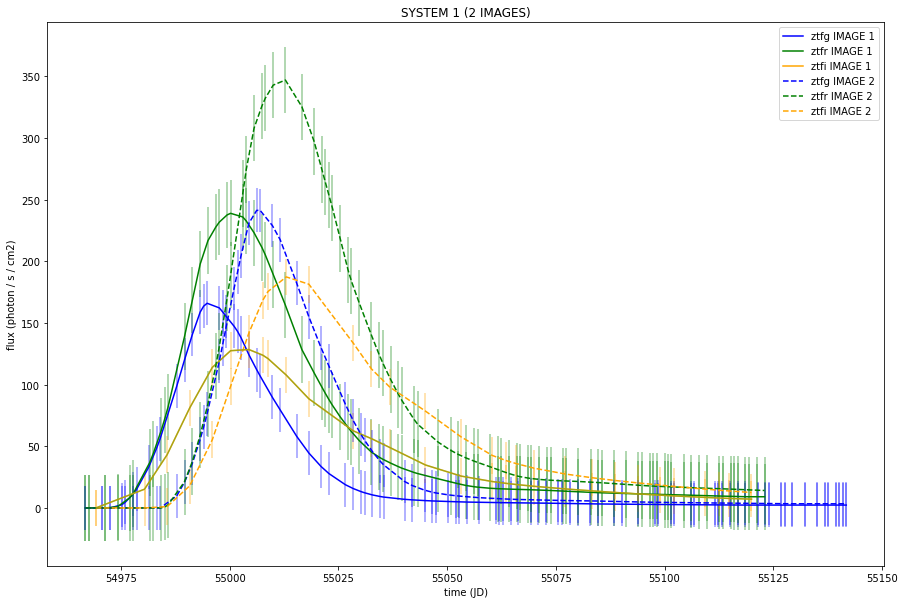

In [20]:
plt.figure(figsize=(15, 10))

# IMAGE 1
# ZTFG
plt.plot(timeS1B1, fluxS1I1B1, color='b', label = 'ztfg IMAGE 1')
plt.errorbar(timeS1B1, fluxS1I1B1, yerr=noiseB1,  fmt='none',  ecolor='b', alpha =0.4)

#ZTGR
plt.plot(timeS1B2, fluxS1I1B2, color='green', label='ztfr IMAGE 1')
plt.errorbar(timeS1B2, fluxS1I1B2, yerr=noiseB2, fmt='none', ecolor='green', alpha =0.4)

#ZTFI
plt.plot(timeS1B3, fluxS1I1B3, color='orange', label='ztfi IMAGE 1')
plt.errorbar(timeS1B3, fluxS1I1B3, yerr=noiseB3,   ecolor='orange', alpha =0.4)


# IMAGE 2
# ZTFG
plt.plot(timeS1B1, fluxS1I2B1, color='b', label='ztfg IMAGE 2', linestyle = 'dashed')
plt.errorbar(timeS1B1, fluxS1I2B1, yerr=noiseB1,  fmt='none',  ecolor='b', alpha =0.4)

# ZTFR
plt.plot(timeS1B2, fluxS1I2B2, color='g', label='ztfr IMAGE 2', linestyle = 'dashed')
plt.errorbar(timeS1B2, fluxS1I2B2, yerr=noiseB2,  fmt='none',  ecolor='g', alpha =0.4)

# ZTGI
plt.plot(timeS1B3, fluxS1I2B3, color='orange', label='ztfi IMAGE 2', linestyle = 'dashed')
plt.errorbar(timeS1B3, fluxS1I2B3, yerr=noiseB3,  fmt='none',  ecolor='orange', alpha =0.4)

plt.title('SYSTEM 1 (2 IMAGES)')
plt.xlabel('time (JD)')
plt.ylabel('flux (photon / s / cm2)')
plt.legend()
plt.show()

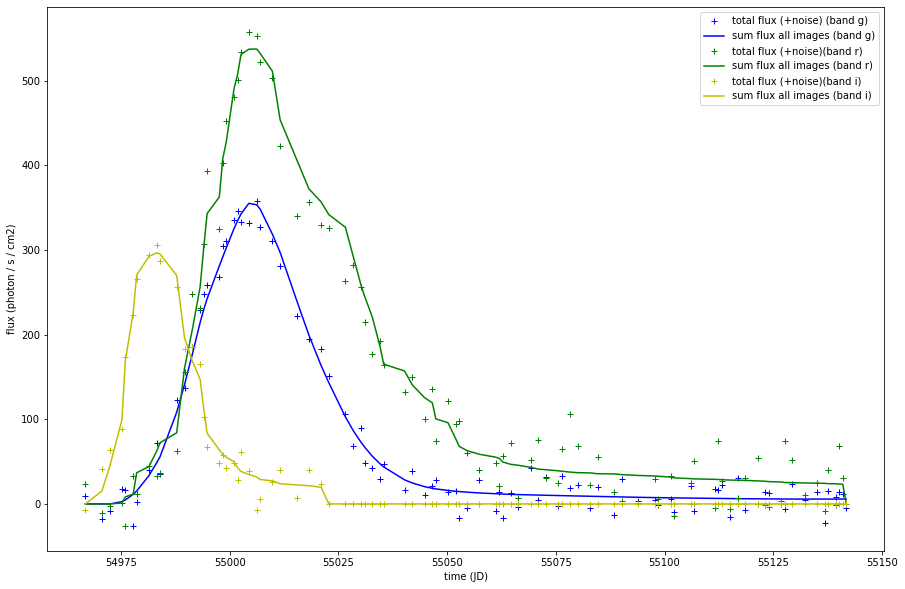

In [10]:
plt.figure(figsize=(15, 10))

# Band g (in blue)

NFS1 = NFluxes[0, :, :]
TfluxG = S1I1[0] + S1I2[0] + S1I3[0] + S1I4[0] 
plt.plot(timeS1B1, NFS1[0], 'b+', label = 'total flux (+noise) (band g)')
plt.plot(timeS1B1, TfluxG, 'b', label = 'sum flux all images (band g)')

# Band r (in green)

TfluxR = S1I1[1] + S1I2[1] + S1I3[1] + S1I4[1] 
plt.plot(timeS1B1, NFS1[1], 'g+', label = 'total flux (+noise)(band r)')
plt.plot(timeS1B1, TfluxR, 'g', label = 'sum flux all images (band r)')

# Band i (in yellow)

TfluxI = S1I1[2] + S1I2[2] + S1I3[2] + S1I4[2] 
plt.plot(timeS1B1, NFS1[2], 'y+', label = 'total flux (+noise)(band i)')
plt.plot(timeS1B1, TfluxI, 'y', label = 'sum flux all images (band i)')

plt.xlabel('time (JD)')
plt.ylabel('flux (photon / s / cm2)')
plt.legend();

In [11]:
TD1FB1 = abs(timeS1B1[np.where(fluxS1I1B1 == fluxS1I1B1.max())[0][0]] - timeS1B1[np.where(fluxS1I2B1 == fluxS1I2B1.max())[0][0]])
TD1FB2 = abs(timeS1B2[np.where(fluxS1I1B2 == fluxS1I1B2.max())[0][0]] - timeS1B2[np.where(fluxS1I2B2 == fluxS1I2B2.max())[0][0]])
TD1FB3 = abs(timeS1B3[np.where(fluxS1I1B3 == fluxS1I1B3.max())[0][0]] - timeS1B3[np.where(fluxS1I2B3 == fluxS1I2B3.max())[0][0]])

d = [ ["Time delay" ,        TD1FB1,  TD1FB2, TD1FB3, (TD1FB1+TD1FB2+TD1FB3)/3]]

df = pd.DataFrame(d, columns = ["   ",'Band g','Band r', 'Band i', 'Mean'])
print(df)

               Band g  Band r  Band i       Mean
0  Time delay    11.4    12.6     8.6  10.866667


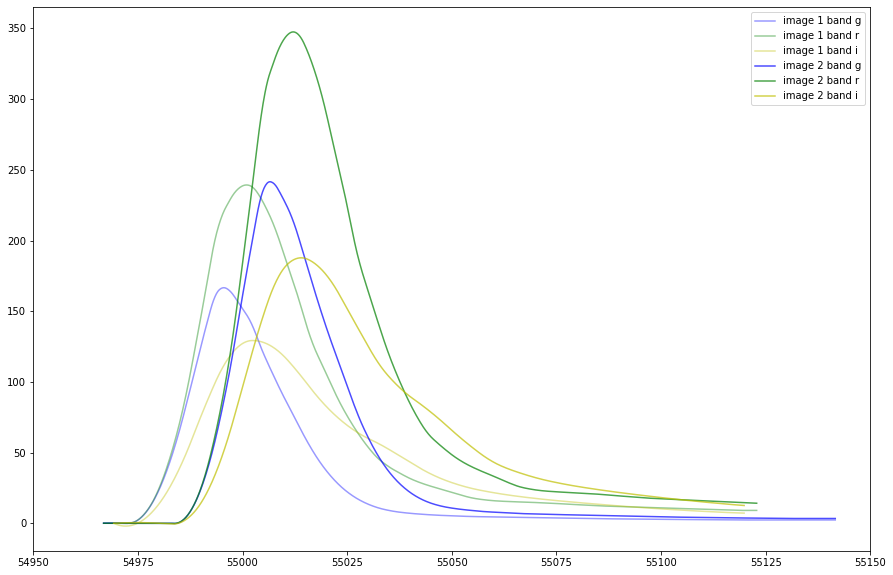

In [12]:
from scipy.interpolate import interp1d

plt.figure(figsize=(15, 10))

x1 = timeS1B1
x1b = np.linspace(min(x1), max(x1), num=1000, endpoint=False)
x2 = timeS1B2
x2b = np.linspace(min(x2), max(x2), num=1000, endpoint=False)
x3 = timeS1B3
x3b = np.linspace(min(x3), max(x3), num=1000, endpoint=False)

# Image 1
y1I1 = fluxS1I1B1
f1I1 = interp1d(x1, y1I1, kind='quadratic')
y2I1 = fluxS1I1B2 
f2I1 = interp1d(x2, y2I1, kind='quadratic')
y3I1 = fluxS1I1B3 
f3I1 = interp1d(x3, y3I1, kind='quadratic')

# Image 2
y1I2 = fluxS1I2B1 
f1I2 = interp1d(x1, y1I2, kind='quadratic')
y2I2 = fluxS1I2B2
f2I2 = interp1d(x2, y2I2, kind='quadratic')
y3I2 = fluxS1I2B3
f3I2 = interp1d(x3, y3I2, kind='quadratic')



plt.plot( x1b, f1I1(x1b), 'b-', alpha = 0.4, label='image 1 band g')
plt.plot( x2b, f2I1(x2b), 'g-', alpha = 0.4, label='image 1 band r')
plt.plot( x3b, f3I1(x3b), 'y-', alpha = 0.4, label='image 1 band i')

plt.plot( x1b, f1I2(x1b), 'b-', alpha = 0.7, label='image 2 band g')
plt.plot( x2b, f2I2(x2b), 'g-', alpha = 0.7, label='image 2 band r')
plt.plot( x3b, f3I2(x3b), 'y-', alpha = 0.7, label='image 2 band i')
plt.legend()
plt.xlim(54950, 55150)
plt.show();

In [13]:
TD1FB1 = abs(x1b[np.where(f1I1(x1b) == max(f1I1(x1b)))[0][0]] - x1b[np.where(f1I2(x1b) == max(f1I2(x1b)))[0][0]])
TD1FB2 = abs(x2b[np.where(f2I1(x2b) == max(f2I1(x2b)))[0][0]] - x2b[np.where(f2I2(x2b) == max(f2I2(x2b)))[0][0]])
TD1FB3 = abs(x3b[np.where(f3I1(x3b) == max(f3I1(x3b)))[0][0]] - x3b[np.where(f3I2(x3b) == max(f3I2(x3b)))[0][0]])

d = [ ["Time delay" ,        TD1FB1,  TD1FB2, TD1FB3, (TD1FB1+TD1FB2+TD1FB3)/3]]

df = pd.DataFrame(d, columns = ["   ",'Band g','Band r', 'Band i', 'Mean'])
print(df)

               Band g   Band r   Band i       Mean
0  Time delay  11.025  11.0902  11.6116  11.242267


## SYSTEM 4: 4 IMAGES

In [14]:
S4I1 = imfluxes[3, 0, :, :]
S4I2 = imfluxes[3, 1, :, :]
S4I3 = imfluxes[3, 2, :, :]
S4I4 = imfluxes[3, 3, :, :]

# Time

timeS4B1 = time[12]
timeS4B2 = time[16]
timeS4B3 = time[20]

# IMAGE 1
fluxS4I1B1 = S4I1[0] 
fluxS4I1B2 = S4I1[1] ; fluxS4I1B2 = fluxS4I1B2[:90]
fluxS4I1B3 = S4I1[2] ; fluxS4I1B3 = fluxS4I1B3[:30]

# IMAGE 2 
fluxS4I2B1 = S4I2[0] 
fluxS4I2B2 = S4I2[1] ; fluxS4I2B2 = fluxS4I2B2[:90]
fluxS4I2B3 = S4I2[2] ; fluxS4I2B3 = fluxS4I2B3[:30]

# IMAGE 3
fluxS4I3B1 = S4I3[0] 
fluxS4I3B2 = S4I3[1] ; fluxS4I3B2 = fluxS4I3B2[:90]
fluxS4I3B3 = S4I3[2] ; fluxS4I3B3 = fluxS4I3B3[:30]

# IMAGE 4
fluxS4I4B1 = S4I4[0] 
fluxS4I4B2 = S4I4[1] ; fluxS4I4B2 = fluxS4I4B2[:90]
fluxS4I4B3 = S4I4[2] ; fluxS4I4B3 = fluxS4I4B3[:30]

#error (relatif aux bandes de filtre) 
noiseS4B1 = Noises[3, 0, 0]
noiseS4B2 = Noises[3, 1, 0]
noiseS4B3 = Noises[3, 2, 0]

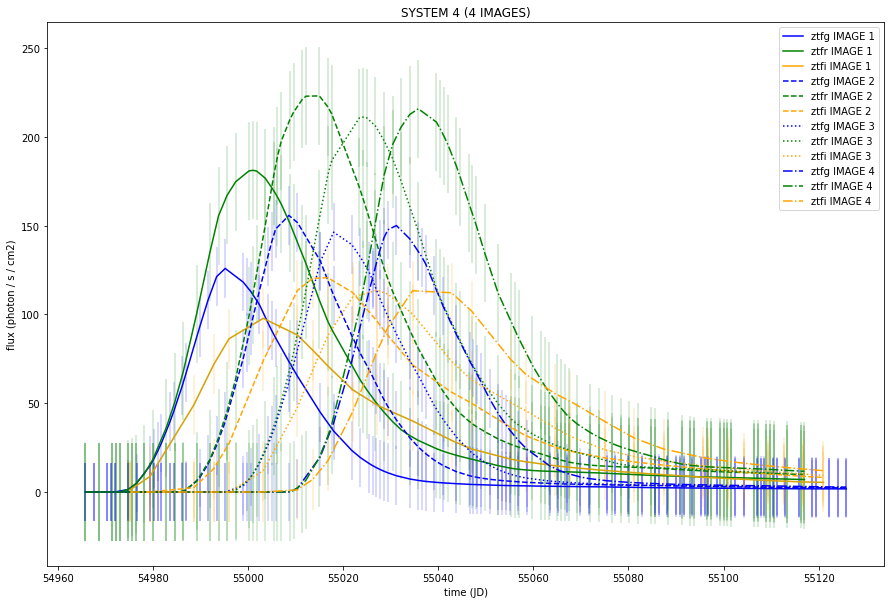

In [15]:
plt.figure(figsize=(15, 10))

# IMAGE 1

# ZTFG
plt.plot(timeS4B1, fluxS4I1B1, color='b', label = 'ztfg IMAGE 1')
plt.errorbar(timeS4B1, fluxS4I1B1, yerr=noiseS4B1, fmt='none', ecolor='b', alpha =0.2)

#ZTGR
plt.plot(timeS4B2, fluxS4I1B2, color='green', label='ztfr IMAGE 1')
plt.errorbar(timeS4B2, fluxS4I1B2, yerr=noiseS4B2, fmt='none', ecolor='green', alpha =0.2)

#ZTFI
plt.plot(timeS4B3, fluxS4I1B3, color='orange', label='ztfi IMAGE 1')
plt.errorbar(timeS4B3, fluxS4I1B3, yerr=noiseS4B3, ecolor='orange', alpha =0.2)


# IMAGE 2
# ZTFG
plt.plot(timeS4B1, fluxS4I2B1, color='b', label='ztfg IMAGE 2', linestyle = 'dashed')
plt.errorbar(timeS4B1, fluxS4I2B1, yerr=noiseS4B1, fmt='none', ecolor='b', alpha =0.2)

# ZTFR
plt.plot(timeS4B2, fluxS4I2B2, color='g', label='ztfr IMAGE 2', linestyle = 'dashed')
plt.errorbar(timeS4B2, fluxS4I2B2, yerr=noiseS4B2,  fmt='none', ecolor='g', alpha =0.2)

# ZTGI
plt.plot(timeS4B3, fluxS4I2B3, color='orange', label='ztfi IMAGE 2', linestyle = 'dashed')
plt.errorbar(timeS4B3, fluxS4I2B3, yerr=noiseS4B3, fmt='none', ecolor='orange', alpha =0.2)


# IMAGE 3
# ZTFG
plt.plot(timeS4B1, fluxS4I3B1, color='b', label='ztfg IMAGE 3', linestyle = 'dotted')
plt.errorbar(timeS4B1, fluxS4I3B1, yerr=noiseS4B1, fmt='none',  ecolor='b', alpha =0.2)

# ZTFR
plt.plot(timeS4B2, fluxS4I3B2, color='g', label='ztfr IMAGE 3', linestyle = 'dotted')
plt.errorbar(timeS4B2, fluxS4I3B2, yerr=noiseS4B2, fmt='none',  ecolor='g', alpha =0.2)

# ZTGI
plt.plot(timeS4B3, fluxS4I3B3, color='orange', label='ztfi IMAGE 3', linestyle = 'dotted')
plt.errorbar(timeS4B3, fluxS4I3B3, yerr=noiseS4B3,  fmt='none',  ecolor='orange', alpha =0.2)


# IMAGE 4
# ZTFG
plt.plot(timeS4B1, fluxS4I4B1, color='b', label='ztfg IMAGE 4', linestyle = '-.')
plt.errorbar(timeS4B1, fluxS4I4B1, yerr=noiseS4B1,  fmt='none',  ecolor='b', alpha =0.2)

# ZTFR
plt.plot(timeS4B2, fluxS4I4B2, color='g', label='ztfr IMAGE 4', linestyle = '-.')
plt.errorbar(timeS4B2, fluxS4I4B2, yerr=noiseS4B2,  fmt='none',  ecolor='g', alpha =0.2)

# ZTGI
plt.plot(timeS4B3, fluxS4I4B3, color='orange', label='ztfi IMAGE 4', linestyle = '-.')
plt.errorbar(timeS4B3, fluxS4I4B3, yerr=noiseS4B3,  fmt='none',  ecolor='orange', alpha =0.2)


plt.title('SYSTEM 4 (4 IMAGES)')
plt.xlabel('time (JD)')
plt.ylabel('flux (photon / s / cm2)')
plt.legend()
plt.show()

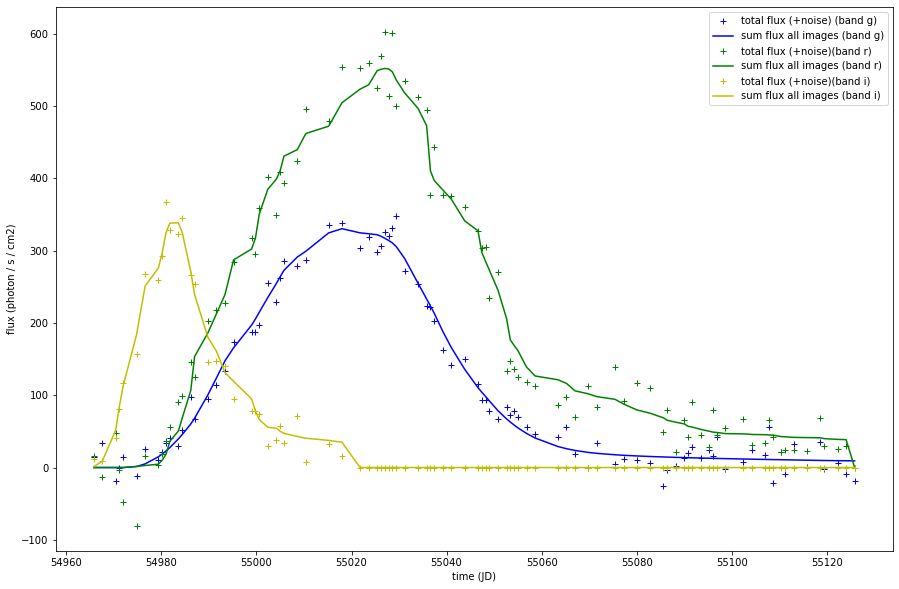

In [16]:
plt.figure(figsize=(15, 10))

# Band g (in blue)

NFS4 = NFluxes[3, :, :]
TfluxG4 = S4I1[0] + S4I2[0] + S4I3[0] + S4I4[0] 
plt.plot(timeS4B1, NFS4[0], 'b+', label = 'total flux (+noise) (band g)')
plt.plot(timeS4B1, TfluxG4, 'b', label = 'sum flux all images (band g)')

# Band r (in green)

TfluxR4 = S4I1[1] + S4I2[1] + S4I3[1] + S4I4[1] 
plt.plot(timeS4B1, NFS4[1], 'g+', label = 'total flux (+noise)(band r)')
plt.plot(timeS4B1, TfluxR4, 'g', label = 'sum flux all images (band r)')

# Band i (in yellow)

TfluxI4 = S4I1[2] + S4I2[2] + S4I3[2] + S4I4[2] 
plt.plot(timeS4B1, NFS4[2], 'y+', label = 'total flux (+noise)(band i)')
plt.plot(timeS4B1, TfluxI4, 'y', label = 'sum flux all images (band i)')

plt.xlabel('time (JD)')
plt.ylabel('flux (photon / s / cm2)')
plt.legend();

In [23]:
# Time delay between the 1st and 2nd images

TD1FB1 = abs(timeS4B1[np.where(fluxS4I1B1 == fluxS4I1B1.max())[0][0]] - timeS4B1[np.where(fluxS4I2B1 == fluxS4I2B1.max())[0][0]])
TD1FB2 = abs(timeS4B2[np.where(fluxS4I1B2 == fluxS4I1B2.max())[0][0]] - timeS4B2[np.where(fluxS4I2B2 == fluxS4I2B2.max())[0][0]])
TD1FB3 = abs(timeS4B3[np.where(fluxS4I1B3 == fluxS4I1B3.max())[0][0]] - timeS4B3[np.where(fluxS4I2B3 == fluxS4I2B3.max())[0][0]])


# Time delay between the 2nd and 3rd images

TD2FB1 = abs(timeS4B1[np.where(fluxS4I2B1 == fluxS4I2B1.max())[0][0]] - timeS4B1[np.where(fluxS4I3B1 == fluxS4I3B1.max())[0][0]])
TD2FB2 = abs(timeS4B2[np.where(fluxS4I2B2 == fluxS4I2B2.max())[0][0]] - timeS4B2[np.where(fluxS4I3B2 == fluxS4I3B2.max())[0][0]])
TD2FB3 = abs(timeS4B3[np.where(fluxS4I2B3 == fluxS4I2B3.max())[0][0]] - timeS4B3[np.where(fluxS4I3B3 == fluxS4I3B3.max())[0][0]])


# Time delay between the 3rd and 4th images

TD3FB1 = abs(timeS4B1[np.where(fluxS4I3B1 == fluxS4I3B1.max())[0][0]] - timeS4B1[np.where(fluxS4I4B1 == fluxS4I4B1.max())[0][0]])
TD3FB2 = abs(timeS4B2[np.where(fluxS4I3B2 == fluxS4I3B2.max())[0][0]] - timeS4B2[np.where(fluxS4I4B2 == fluxS4I4B2.max())[0][0]])
TD3FB3 = abs(timeS4B3[np.where(fluxS4I3B3 == fluxS4I3B3.max())[0][0]] - timeS4B3[np.where(fluxS4I4B3 == fluxS4I4B3.max())[0][0]])


d = [ ["Time delay between 1-2 images" ,  TD1FB1,  TD1FB2, TD1FB3, (TD1FB1+TD1FB2+TD1FB3)/3],
      ["Time delay between 2-3 images",  TD2FB1, TD2FB2, TD2FB3, (TD2FB1+TD2FB2+TD2FB3)/3],
      ["Time delay between 3-4 images",  TD3FB1, TD3FB2, TD3FB3, (TD3FB1+TD3FB2+TD3FB3)/3 ]]

df = pd.DataFrame(d, columns = ["   ",'Band g','Band r', 'Band i', 'Mean'])
print(df)


                                  Band g  Band r  Band i       Mean
0  Time delay between 1-2 images    13.4    14.0    13.6  13.666667
1  Time delay between 2-3 images     9.4     9.2    10.4   9.666667
2  Time delay between 3-4 images    13.2    11.6     7.4  10.733333


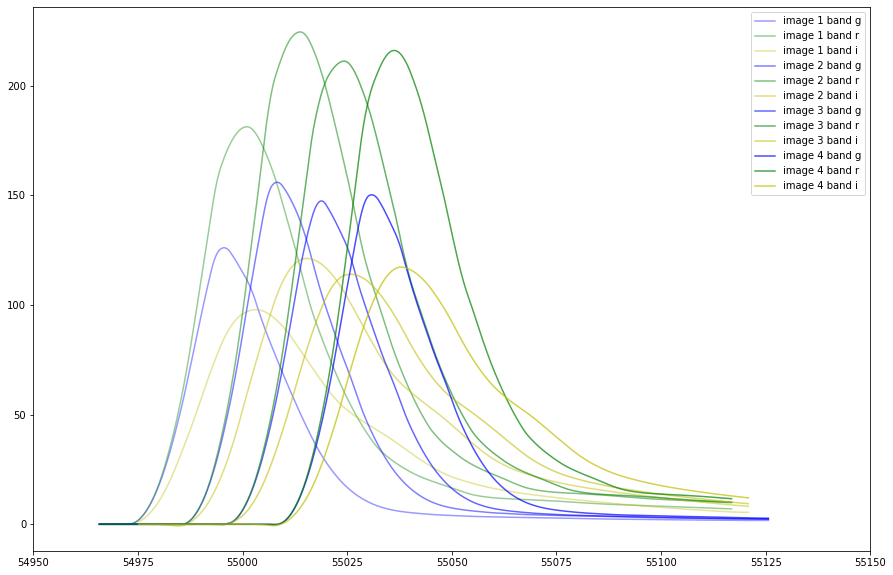

In [18]:
plt.figure(figsize=(15, 10))

x1 = timeS4B1
x1b = np.linspace(min(x1), max(x1), num=1000, endpoint=False)
x2 = timeS4B2
x2b = np.linspace(min(x2), max(x2), num=1000, endpoint=False)
x3 = timeS4B3
x3b = np.linspace(min(x3), max(x3), num=1000, endpoint=False)

# Image 1
y1I1 = fluxS4I1B1 
f1I1 = interp1d(x1, y1I1, kind='quadratic')
y2I1 = fluxS4I1B2
f2I1 = interp1d(x2, y2I1, kind='quadratic')
y3I1 = fluxS4I1B3
f3I1 = interp1d(x3, y3I1, kind='quadratic')

# Image 2
y1I2 = fluxS4I2B1
f1I2 = interp1d(x1, y1I2, kind='quadratic')
y2I2 = fluxS4I2B2
f2I2 = interp1d(x2, y2I2, kind='quadratic')
y3I2 = fluxS4I2B3
f3I2 = interp1d(x3, y3I2, kind='quadratic')

# Image 3
y1I3 = fluxS4I3B1
f1I3 = interp1d(x1, y1I3, kind='quadratic')
y2I3 = fluxS4I3B2
f2I3 = interp1d(x2, y2I3, kind='quadratic')
y3I3 = fluxS4I3B3
f3I3 = interp1d(x3, y3I3, kind='quadratic')

# Image 4
y1I4 = fluxS4I4B1
f1I4 = interp1d(x1, y1I4, kind='quadratic')
y2I4 = fluxS4I4B2
f2I4 = interp1d(x2, y2I4, kind='quadratic')
y3I4 = fluxS4I4B3
f3I4 = interp1d(x3, y3I4, kind='quadratic')



plt.plot( x1b, f1I1(x1b), 'b-', alpha = 0.4, label='image 1 band g')
plt.plot( x2b, f2I1(x2b), 'g-', alpha = 0.4, label='image 1 band r')
plt.plot( x3b, f3I1(x3b), 'y-', alpha = 0.4, label='image 1 band i')

plt.plot( x1b, f1I2(x1b), 'b-', alpha = 0.5, label='image 2 band g')
plt.plot( x2b, f2I2(x2b), 'g-', alpha = 0.5, label='image 2 band r')
plt.plot( x3b, f3I2(x3b), 'y-', alpha = 0.5, label='image 2 band i')

plt.plot( x1b, f1I3(x1b), 'b-', alpha = 0.6, label='image 3 band g')
plt.plot( x2b, f2I3(x2b), 'g-', alpha = 0.6, label='image 3 band r')
plt.plot( x3b, f3I3(x3b), 'y-', alpha = 0.6, label='image 3 band i')

plt.plot( x1b, f1I4(x1b), 'b-', alpha = 0.7, label='image 4 band g')
plt.plot( x2b, f2I4(x2b), 'g-', alpha = 0.7, label='image 4 band r')
plt.plot( x3b, f3I4(x3b), 'y-', alpha = 0.7, label='image 4 band i')

plt.legend()
plt.xlim(54950, 55150)
plt.show();

In [19]:
# Time delay between the 1st and 2nd images

TD1FB1 = abs(x1b[np.where(f1I1(x1b) == max(f1I1(x1b)))[0][0]] - x1b[np.where(f1I2(x1b) == max(f1I2(x1b)))[0][0]])
TD1FB2 = abs(x2b[np.where(f2I1(x2b) == max(f2I1(x2b)))[0][0]] - x2b[np.where(f2I2(x2b) == max(f2I2(x2b)))[0][0]])
TD1FB3 = abs(x3b[np.where(f3I1(x3b) == max(f3I1(x3b)))[0][0]] - x3b[np.where(f3I2(x3b) == max(f3I2(x3b)))[0][0]])


# Time delay between the 2nd and 3rd images

TD2FB1 = abs(x1b[np.where(f1I2(x1b) == max(f1I2(x1b)))[0][0]] - x1b[np.where(f1I3(x1b) == max(f1I3(x1b)))[0][0]])
TD2FB2 = abs(x2b[np.where(f2I2(x2b) == max(f2I2(x2b)))[0][0]] - x2b[np.where(f2I3(x2b) == max(f2I3(x2b)))[0][0]])
TD2FB3 = abs(x3b[np.where(f3I2(x3b) == max(f3I2(x3b)))[0][0]] - x3b[np.where(f3I3(x3b) == max(f3I3(x3b)))[0][0]])


# Time delay between the 3rd and 4th images

TD3FB1 = abs(x1b[np.where(f1I3(x1b) == max(f1I3(x1b)))[0][0]] - x1b[np.where(f1I4(x1b) == max(f1I4(x1b)))[0][0]])
TD3FB2 = abs(x2b[np.where(f2I3(x2b) == max(f2I3(x2b)))[0][0]] - x2b[np.where(f2I4(x2b) == max(f2I4(x2b)))[0][0]])
TD3FB3 = abs(x3b[np.where(f3I3(x3b) == max(f3I3(x3b)))[0][0]] - x3b[np.where(f3I4(x3b) == max(f3I4(x3b)))[0][0]])


d = [ ["Time delay between 1-2 images" ,  TD1FB1,  TD1FB2, TD1FB3, (TD1FB1+TD1FB2+TD1FB3)/3],
      ["Time delay between 2-3 images",  TD2FB1, TD2FB2, TD2FB3, (TD2FB1+TD2FB2+TD2FB3)/3],
      ["Time delay between 3-4 images",  TD3FB1, TD3FB2, TD3FB3, (TD3FB1+TD3FB2+TD3FB3)/3]]

df = pd.DataFrame(d, columns = ["   ",'Band g','Band r', 'Band i', 'mean'])
print(df)

                                  Band g   Band r   Band i       mean
0  Time delay between 1-2 images   12.64  12.7008  11.9556  12.432133
1  Time delay between 2-3 images   10.72  10.5840  10.6434  10.649133
2  Time delay between 3-4 images   12.00  11.9448  12.1014  12.015400
